## 安装方式(release的最新版本)： 
安装vnpy_fxdayu:

https://github.com/xingetouzi/vnpy_fxdayu/tree/release-1.1.13.dev1811227

## 配置引擎参数

In [1]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
from talib import abstract

In [25]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181130 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [3]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

## 策略编写与参数设置

参数与变量的区别: 参数用来传递并且可以优化，变量是随着过程的赋值改变的

## CtaTemplate 继承的属性与方法
1. self.symbolList: 支持多品种以列表格式输入引擎
2. self.posDict: 可记录多个品种的多空持仓的字典
3. self.cancelAll(): 取消所有订单
4. self.getArrayManager(symbol, freq): 数组管理器

In [41]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiSignalStrategy(CtaTemplate):
    className = 'MultiSignalStrategy'
    author = 'LuYiming'
    
   # 参数设置
    short_roc_period = 7
    fastPeriod = 5; slowPeriod = 30
    roc_period = 20
    roc_10_ma1_period = 8;roc_10_ma2_period = 18
    roc_ma1_period = 5;roc_ma2_period = 25
    lot = 1
    stopLossPct = 0.01; takeProfitPct=0.3; protectPct=0.1
    
#     varList = ['barPeriod']  
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 100
    tmp = 0
    condition = 0
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    RSI = {};CCI = {};ROC_MA = {};VWAP = {}
    stopProtect = {}
    
    
    # 参数列表
    paramList = ['short_roc_period','roc_period','roc_10_ma1_period','roc_10_ma2_period','stopRatio','fastPeriod','slowPeriod']    
    
    # 变量列表
    varList = ['barPeriod','transactionPrice','intraTradeHighDict', 'intraTradeLowDict',
              'CCI', 'VWAP', 'ROC_MA']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.ROC_MA = {s:0 for s in self.symbolList}
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        am = self.getArrayManager(symbol, "1m")

        if not am.inited:
            return
        
        # 优化金字塔加仓模块________________________________________________
        
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 5):    # 持有多头仓位并且加仓次数不超过5次
            if self.transactionPrice[symbol]>bar.close and self.condition == 1:   # 当前是盈利状况，并且满足上述加仓条件
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize*(0.3-self.nPos*0.05))  # 目标加仓100手  分别为加仓 30手、25手、20手，15手，10手
                self.tmp = 0  # 置零两个临时的控制变量
                self.condition = 0
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 5):    # 持有空头仓位并且加仓次数不超过5次
            if bar.close>self.transactionPrice[symbol] and self.condition == -1:   # 当前是盈利状况，并且满足上述加仓条件
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize*(0.3-self.nPos*0.05))  # 目标加仓100手  分别为加仓 30手、25手、20手，15手，10手
                self.tmp = 0  # 置零两个临时的控制变量
                self.condition = 0
        
        # 发出状态更新事件
        self.putEvent()
    
    #----------------------------------------------------------------------
    
    def on15MinBar(self, bar):
        symbol = bar.vtSymbol
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        fastMa = ta.MA(am15.close, self.fastPeriod)
        slowMa = ta.MA(am15.close, self.slowPeriod)
        if (fastMa[-1] > slowMa[-1]) and (fastMa[-2] < slowMa[-2]):
            self.ROC_MA[symbol] = 1
        elif (fastMa[-1] < slowMa[-1]) and (fastMa[-2] > slowMa[-2]):
            self.ROC_MA[symbol] = -1
            
        ROC_10 = ta.ROC(am15.close, self.short_roc_period)
        roc_10_ma1 = ta.MA(ROC_10, self.roc_10_ma1_period)
        roc_10_ma2 = ta.MA(ROC_10, self.roc_10_ma2_period)
        
        if (roc_10_ma1[-1] > roc_10_ma2[-1]) and (roc_10_ma1[-2] <= roc_10_ma2[-2]):
            self.ROC_MA[symbol] += 1
        elif (roc_10_ma1[-1] < roc_10_ma2[-1]) and (roc_10_ma1[-2] >= roc_10_ma2[-2]):
            self.ROC_MA[symbol] += -1
        else:
            self.ROC_MA[symbol] = 0
        
#         # 发出状态更新事件
        self.putEvent()
        
    def on60minBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        ROC = ta.ROC(am60.close, self.roc_period)
        
        roc_ma1 = ta.MA(ROC, self.roc_ma1_period)
        roc_ma2 = ta.MA(ROC, self.roc_ma2_period)
        
        # 现象条件
        breakUp = (roc_ma1[-1] > roc_ma2[-1]) and (roc_ma1[-2] <= roc_ma2[-2])
        breakDn =  (roc_ma1[-1] < roc_ma2[-1]) and (roc_ma1[-2] >= roc_ma2[-2])
        Signal = self.ROC_MA[symbol]
        
#         long = fastMa[-1]>fastMa[-2] and slowMa[-1]>slowMa[-2]   # 多头排列
#         short = fastMa[-1]<fastMa[-2] and slowMa[-1]<slowMa[-2]
        
        # 进出场条件
        if (Signal>=1) and breakUp:
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.05, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.05, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.05, self.lot)
        elif breakDn and (Signal>=-2):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.95, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.95, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.95, self.lot)
        elif ((Signal==1) and breakDn) or (breakUp and (Signal==-1)):
            # 有多平多，有空平空
            if self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG'])
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT'])
        
    
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 10:18:04.932817	开始回测
2018-12-23 10:18:04.932817	策略初始化
2018-12-23 10:18:05.429488	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 10:18:05.429488	初始化预加载数据成功, 数据长度:12000
2018-12-23 10:18:05.429488	策略初始化完成
2018-12-23 10:18:05.429488	策略启动完成
2018-12-23 10:18:05.429488	回测时间范围:[20180601 12:00,20181123 12:00)
2018-12-23 10:18:05.429488	当前回放的时间段:[20180601 12:00,20181123 12:00)
2018-12-23 10:18:15.751910	数据载入完成, 时间段:[20180601 12:00,20181123 12:00);数据量:250208
2018-12-23 10:18:15.917431	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 10:18:17.597936	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 10:18:17.604919	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 10:18:40.837777	回放结束ress: 100%    
2018-12-23 10:18:40.837777	计算按日统计结果
2018-12-23 10:18:40.866738	------------------------------
2018-12-23 10:18:40.867695	首个交易日：	2018-06-01 00:00:00
2018-12-23 1

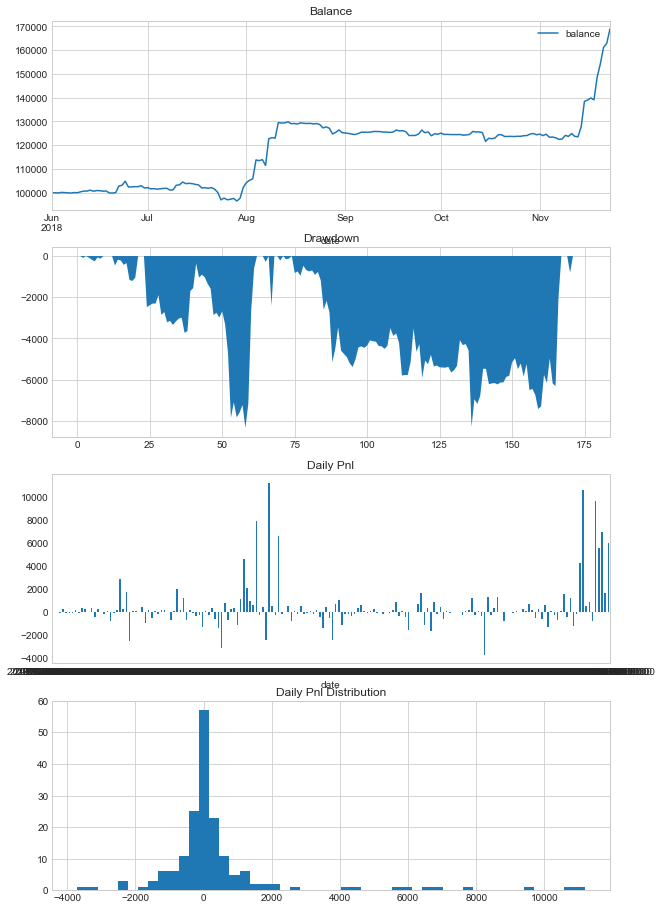

2018-12-23 10:18:43.697162	计算回测结果
2018-12-23 10:18:43.704109	------------------------------
2018-12-23 10:18:43.704109	第一笔交易：	2018-06-09 03:00:00
2018-12-23 10:18:43.704109	最后一笔交易：	2018-11-23 11:58:00
2018-12-23 10:18:43.704109	总交易次数：	117
2018-12-23 10:18:43.704109	总盈亏：	68,784.41
2018-12-23 10:18:43.704109	最大回撤: 	-5,968.63
2018-12-23 10:18:43.704109	平均每笔盈利：	587.9
2018-12-23 10:18:43.704109	平均每笔滑点：	0.0
2018-12-23 10:18:43.704109	平均每笔佣金：	6.36
2018-12-23 10:18:43.704109	胜率		64.1%
2018-12-23 10:18:43.704109	盈利交易平均值	1,036.71
2018-12-23 10:18:43.704109	亏损交易平均值	-213.55
2018-12-23 10:18:43.704109	盈亏比：	4.85


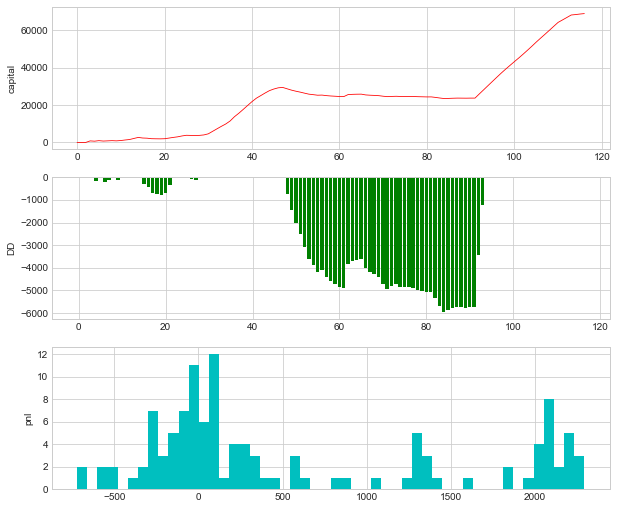

2018-12-23 10:18:44.321458	计算按日统计结果


,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-06-01,0.000000,0.000,0.000000,0.00,0,0.00,0.00,0.00
2018-06-02,0.000000,0.000,0.000000,0.00,0,0.00,0.00,0.00
2018-06-03,-92.412710,0.002,3.820710,7641.42,1,-88.59,0.00,-88.59
2018-06-04,233.020000,0.000,0.000000,0.00,0,0.00,233.02,233.02
2018-06-05,-80.100000,0.000,0.000000,0.00,0,0.00,-80.10,-80.10
2018-06-06,-97.736995,0.002,3.814995,7629.99,1,-20.51,-73.41,-93.92
2018-06-07,-81.860000,0.000,0.000000,0.00,0,0.00,-81.86,-81.86
2018-06-08,191.640420,0.002,3.847580,7695.16,1,67.65,127.84,195.49
2018-06-09,-61.621445,0.008,15.253445,30506.89,2,-98.89,52.53,-46.36


In [42]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
# engine.initStrategy(Strategy, parameterDict)    # 创建策略对象
# engine.runBacktesting()
runBacktesting(MultiSignalStrategy, parameterDict, '20180601 12:00', '20181123 12:00', 0.002, 5/10000)

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-12-23 10:10:51.101598	开始回测
2018-12-23 10:10:51.101598	策略初始化
2018-12-23 10:10:51.644177	数据载入完成, 时间段:[20180623 04:00,20180701 12:00);数据量:11295
2018-12-23 10:10:51.644177	初始化预加载数据成功, 数据长度:11295
2018-12-23 10:10:51.644177	策略初始化完成
2018-12-23 10:10:51.644177	策略启动完成
2018-12-23 10:10:51.644177	回测时间范围:[20180701 12:00,20181123 12:00)
2018-12-23 10:10:51.644177	当前回放的时间段:[20180701 12:00,20181123 12:00)
2018-12-23 10:11:00.861488	数据载入完成, 时间段:[20180701 12:00,20181123 12:00);数据量:207713
2018-12-23 10:11:01.125780	数据载入完成, 时间段:[20180630 20:51,20180703 12:01);数据量:3790
2018-12-23 10:11:03.266057	数据载入完成, 时间段:[20180524 15:00,20180630 20:50);数据量:47285
2018-12-23 10:11:03.277025	WARNING: 该时间段:[20180703 12:01,20180703 13:00) 数据量为0!
2018-12-23 10:11:23.479985	回放结束ress: 100%    
2018-12-23 10:11:23.479985	计算按日统计结果
2018-12-23 10:11:23.506910	------------------------------
2018-12-23 10:11:23.507908	首个交易日：	2018-07-01 00:00:00
2018-12-23 1

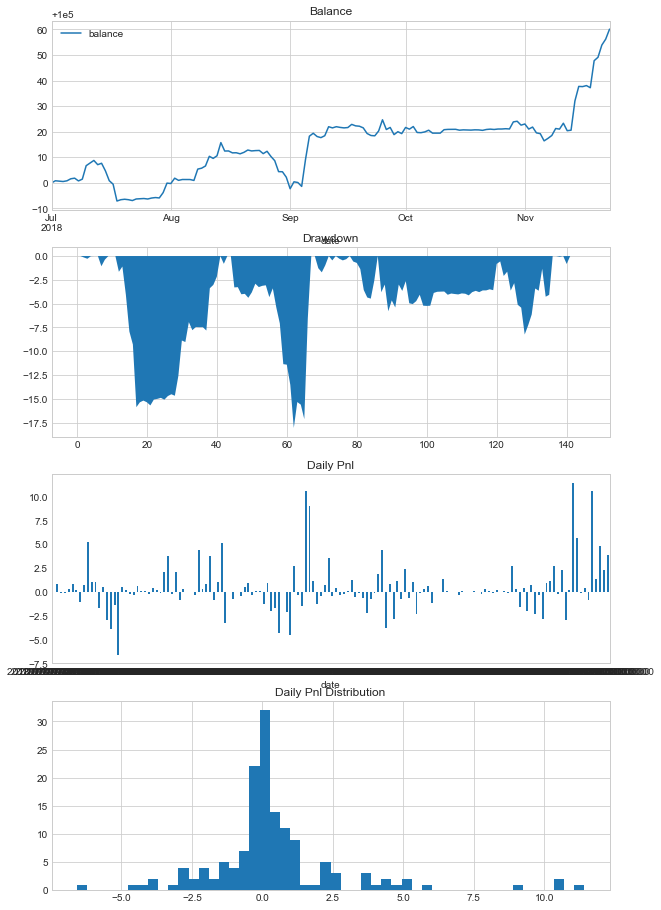

2018-12-23 10:11:25.810748	计算回测结果
2018-12-23 10:11:25.822719	------------------------------
2018-12-23 10:11:25.822719	第一笔交易：	2018-07-02 20:00:00
2018-12-23 10:11:25.822719	最后一笔交易：	2018-11-23 11:58:00
2018-12-23 10:11:25.822719	总交易次数：	103
2018-12-23 10:11:25.822719	总盈亏：	60.01
2018-12-23 10:11:25.822719	最大回撤: 	-8.17
2018-12-23 10:11:25.822719	平均每笔盈利：	0.58
2018-12-23 10:11:25.822719	平均每笔滑点：	0.0
2018-12-23 10:11:25.822719	平均每笔佣金：	0.01
2018-12-23 10:11:25.822719	胜率		71.84%
2018-12-23 10:11:25.822719	盈利交易平均值	0.98
2018-12-23 10:11:25.822719	亏损交易平均值	-0.44
2018-12-23 10:11:25.822719	盈亏比：	2.22


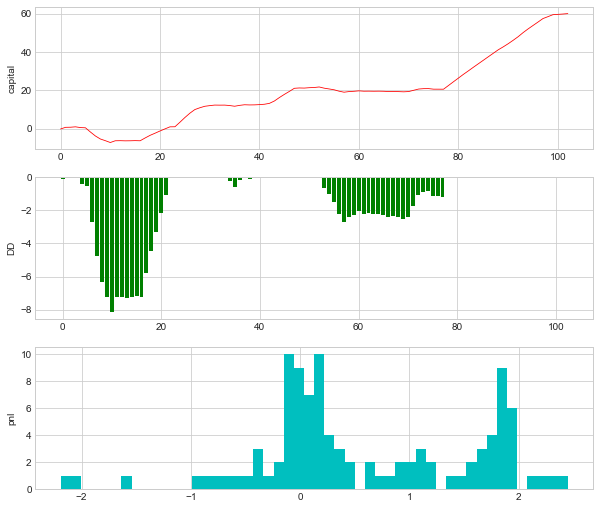

2018-12-23 10:11:26.306423	计算按日统计结果


,netPnl,slippage,commission,turnover,tradeCount,tradingPnl,positionPnl,totalPnl
date,,,,,,,,
2018-07-01,0.000000,0.000,0.000000,0.0000,0,0.0000,0.0000,0.0000
2018-07-02,0.825615,0.006,0.011985,23.9700,3,0.8436,0.0000,0.8436
2018-07-03,-0.151893,0.004,0.008893,17.7868,2,-0.2112,0.0722,-0.1390
2018-07-04,-0.135500,0.000,0.000000,0.0000,0,0.0000,-0.1355,-0.1355
2018-07-05,0.270175,0.002,0.004525,9.0498,1,0.0960,0.1807,0.2767
2018-07-06,0.795800,0.000,0.000000,0.0000,0,0.0000,0.7958,0.7958
2018-07-07,0.241400,0.000,0.000000,0.0000,0,0.0000,0.2414,0.2414
2018-07-08,-1.072722,0.002,0.004222,8.4445,1,-0.3493,-0.7172,-1.0665
2018-07-09,0.694730,0.002,0.004370,8.7401,1,0.1350,0.5661,0.7011


In [36]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
# engine.initStrategy(Strategy, parameterDict)    # 创建策略对象
# engine.runBacktesting()
runBacktesting(MultiSignalStrategy, parameterDict, '20180701 12:00', '20181123 12:00', 0.002, 5/10000)

In [26]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')       # 设置优化排序的目标是夏普
setting.addParameter('short_roc_period', 5, 15, 2)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('roc_10_ma1_period', 6, 12, 2)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('roc_10_ma2_period', 16, 24, 2)

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiSignalStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(Strategy, setting)
# print('耗时：%s' %(time.time()-start))

2018-12-23 08:48:02.905080	------------------------------
2018-12-23 08:48:02.905080	setting: {'short_roc_period': 5, 'roc_10_ma1_period': 6, 'roc_10_ma2_period': 16, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 08:48:02.907076	开始回测
2018-12-23 08:48:02.907076	策略初始化
2018-12-23 08:48:03.371831	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 08:48:03.372834	初始化预加载数据成功, 数据长度:12000
2018-12-23 08:48:03.372834	策略初始化完成
2018-12-23 08:48:03.372834	策略启动完成
2018-12-23 08:48:03.372834	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 08:48:03.372834	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 08:48:14.781315	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 08:48:14.935896	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 08:48:16.525648	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 08:48:16.531630	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018

2018-12-23 08:52:25.172516	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 08:52:25.346084	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 08:52:26.918881	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 08:52:26.923831	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 08:52:48.985816	回放结束ress: 100%    
2018-12-23 08:52:48.985816	计算按日统计结果
2018-12-23 08:52:49.099514	------------------------------
2018-12-23 08:52:49.099514	setting: {'short_roc_period': 5, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 08:52:49.119460	开始回测
2018-12-23 08:52:49.119460	策略初始化
2018-12-23 08:52:49.731821	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 08:52:49.732818	初始化预加载数据成功, 数据长度:12000
2018-12-23 08:52:49.732818	策略初始化完成
2018-12-23 08:52:49.732818	策略启动完成
2018-12-23 08:52:49.732818	回测时间范围:[20180601 12:00,201811

2018-12-23 08:57:04.786588	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 08:57:04.786588	初始化预加载数据成功, 数据长度:12000
2018-12-23 08:57:04.787550	策略初始化完成
2018-12-23 08:57:04.787550	策略启动完成
2018-12-23 08:57:04.787550	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 08:57:04.787550	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 08:57:17.300080	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 08:57:17.469663	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 08:57:19.619876	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 08:57:19.626858	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 08:57:43.800194	回放结束ress: 100%    
2018-12-23 08:57:43.800194	计算按日统计结果
2018-12-23 08:57:43.952784	------------------------------
2018-12-23 08:57:43.953786	setting: {'short_roc_period': 5, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binan

2018-12-23 09:02:10.339204	回放结束ress: 100%    
2018-12-23 09:02:10.339204	计算按日统计结果
2018-12-23 09:02:10.458886	------------------------------
2018-12-23 09:02:10.459881	setting: {'short_roc_period': 7, 'roc_10_ma1_period': 6, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:02:10.482820	开始回测
2018-12-23 09:02:10.482820	策略初始化
2018-12-23 09:02:10.900704	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:02:10.901703	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:02:10.901703	策略初始化完成
2018-12-23 09:02:10.901703	策略启动完成
2018-12-23 09:02:10.901703	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:02:10.901703	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:02:21.636983	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:02:21.782628	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:02:23.708478	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
20

2018-12-23 09:06:41.680885	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:06:41.828516	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:06:43.784284	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:06:43.790234	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:07:05.618845	回放结束ress: 100%    
2018-12-23 09:07:05.619843	计算按日统计结果
2018-12-23 09:07:05.732540	------------------------------
2018-12-23 09:07:05.732540	setting: {'short_roc_period': 7, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:07:05.754480	开始回测
2018-12-23 09:07:05.755510	策略初始化
2018-12-23 09:07:06.173360	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:07:06.174359	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:07:06.174359	策略初始化完成
2018-12-23 09:07:06.174359	策略启动完成
2018-12-23 09:07:06.174359	回测时间范围:[20180601 12:00,20181

2018-12-23 09:11:15.192273	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:11:15.192273	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:11:15.192273	策略初始化完成
2018-12-23 09:11:15.192273	策略启动完成
2018-12-23 09:11:15.192273	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:11:15.192273	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:11:24.766626	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:11:24.911242	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:11:27.246994	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:11:27.252976	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:11:48.894121	回放结束ress: 100%    
2018-12-23 09:11:48.894121	计算按日统计结果
2018-12-23 09:11:49.007785	------------------------------
2018-12-23 09:11:49.007785	setting: {'short_roc_period': 7, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binan

2018-12-23 09:15:44.290406	回放结束ress: 100%    
2018-12-23 09:15:44.290406	计算按日统计结果
2018-12-23 09:15:44.409087	------------------------------
2018-12-23 09:15:44.409087	setting: {'short_roc_period': 9, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:15:44.428072	开始回测
2018-12-23 09:15:44.429035	策略初始化
2018-12-23 09:15:44.825972	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:15:44.826970	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:15:44.826970	策略初始化完成
2018-12-23 09:15:44.826970	策略启动完成
2018-12-23 09:15:44.826970	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:15:44.826970	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:15:54.332585	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:15:54.481145	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:15:56.041971	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
20

2018-12-23 09:19:51.269741	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:19:51.416347	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:19:53.051973	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:19:53.057956	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:20:15.085067	回放结束ress: 100%    
2018-12-23 09:20:15.085067	计算按日统计结果
2018-12-23 09:20:15.197731	------------------------------
2018-12-23 09:20:15.197731	setting: {'short_roc_period': 9, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:20:15.217681	开始回测
2018-12-23 09:20:15.217681	策略初始化
2018-12-23 09:20:15.637555	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:20:15.638556	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:20:15.638556	策略初始化完成
2018-12-23 09:20:15.638556	策略启动完成
2018-12-23 09:20:15.638556	回测时间范围:[20180601 12:00,20181

2018-12-23 09:24:15.265676	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:24:15.265676	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:24:15.265676	策略初始化完成
2018-12-23 09:24:15.265676	策略启动完成
2018-12-23 09:24:15.265676	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:24:15.265676	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:24:24.646562	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:24:24.981651	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:24:27.599683	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:24:27.605635	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:24:51.077846	回放结束ress: 100%    
2018-12-23 09:24:51.078843	计算按日统计结果
2018-12-23 09:24:51.190544	------------------------------
2018-12-23 09:24:51.190544	setting: {'short_roc_period': 11, 'roc_10_ma1_period': 6, 'roc_10_ma2_period': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binan

2018-12-23 09:28:52.307144	回放结束ress: 100%    
2018-12-23 09:28:52.308139	计算按日统计结果
2018-12-23 09:28:52.421836	------------------------------
2018-12-23 09:28:52.421836	setting: {'short_roc_period': 11, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 24, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:28:52.441782	开始回测
2018-12-23 09:28:52.441782	策略初始化
2018-12-23 09:28:53.141942	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:28:53.141942	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:28:53.142907	策略初始化完成
2018-12-23 09:28:53.142907	策略启动完成
2018-12-23 09:28:53.142907	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:28:53.142907	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:29:03.007518	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:29:03.157152	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:29:04.904486	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2

2018-12-23 09:33:18.028341	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:33:18.172955	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:33:19.790631	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:33:19.796613	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:33:45.097932	回放结束ress: 100%    
2018-12-23 09:33:45.097932	计算按日统计结果
2018-12-23 09:33:45.208636	------------------------------
2018-12-23 09:33:45.208636	setting: {'short_roc_period': 11, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:33:45.226589	开始回测
2018-12-23 09:33:45.226589	策略初始化
2018-12-23 09:33:45.637488	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:33:45.637488	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:33:45.637488	策略初始化完成
2018-12-23 09:33:45.637488	策略启动完成
2018-12-23 09:33:45.637488	回测时间范围:[20180601 12:00,2018

2018-12-23 09:37:50.810652	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:37:50.810652	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:37:50.810652	策略初始化完成
2018-12-23 09:37:50.810652	策略启动完成
2018-12-23 09:37:50.810652	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:37:50.810652	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:38:00.608443	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:38:00.882709	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:38:02.611120	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:38:02.617072	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:38:24.220282	回放结束ress: 100%    
2018-12-23 09:38:24.221279	计算按日统计结果
2018-12-23 09:38:24.333981	------------------------------
2018-12-23 09:38:24.334975	setting: {'short_roc_period': 13, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 16, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binan

2018-12-23 09:42:26.864396	回放结束ress: 100%    
2018-12-23 09:42:26.864396	计算按日统计结果
2018-12-23 09:42:26.987102	------------------------------
2018-12-23 09:42:26.987102	setting: {'short_roc_period': 13, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:42:27.008014	开始回测
2018-12-23 09:42:27.008014	策略初始化
2018-12-23 09:42:27.407977	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:42:27.407977	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:42:27.407977	策略初始化完成
2018-12-23 09:42:27.407977	策略启动完成
2018-12-23 09:42:27.407977	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:42:27.407977	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:42:36.526555	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:42:36.685126	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:42:38.606991	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469


2018-12-23 09:46:37.740214	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:46:37.896758	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:46:40.400096	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:46:40.406047	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:47:03.816423	回放结束ress: 100%    
2018-12-23 09:47:03.816423	计算按日统计结果
2018-12-23 09:47:03.928124	------------------------------
2018-12-23 09:47:03.928124	setting: {'short_roc_period': 15, 'roc_10_ma1_period': 6, 'roc_10_ma2_period': 16, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:47:03.947076	开始回测
2018-12-23 09:47:03.947076	策略初始化
2018-12-23 09:47:04.360968	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:47:04.360968	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:47:04.360968	策略初始化完成
2018-12-23 09:47:04.360968	策略启动完成
2018-12-23 09:47:04.360968	回测时间范围:[20180601 12:00,20181

2018-12-23 09:51:16.209310	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:51:16.210273	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:51:16.210273	策略初始化完成
2018-12-23 09:51:16.210273	策略启动完成
2018-12-23 09:51:16.210273	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:51:16.211273	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:51:25.331878	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:51:25.491446	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:51:27.358452	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469
2018-12-23 09:51:27.364438	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-23 09:51:49.005546	回放结束ress: 100%    
2018-12-23 09:51:49.006543	计算按日统计结果
2018-12-23 09:51:49.119243	------------------------------
2018-12-23 09:51:49.120241	setting: {'short_roc_period': 15, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binan

2018-12-23 09:56:08.542325	回放结束ress: 100%    
2018-12-23 09:56:08.542325	计算按日统计结果
2018-12-23 09:56:08.674934	------------------------------
2018-12-23 09:56:08.674934	setting: {'short_roc_period': 15, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 16, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-23 09:56:08.699867	开始回测
2018-12-23 09:56:08.699867	策略初始化
2018-12-23 09:56:09.348135	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-23 09:56:09.349132	初始化预加载数据成功, 数据长度:12000
2018-12-23 09:56:09.350128	策略初始化完成
2018-12-23 09:56:09.350128	策略启动完成
2018-12-23 09:56:09.351126	回测时间范围:[20180601 12:00,20181130 12:00)
2018-12-23 09:56:09.351126	当前回放的时间段:[20180601 12:00,20181130 12:00)
2018-12-23 09:56:20.373642	数据载入完成, 时间段:[20180601 12:00,20181130 12:00);数据量:260288
2018-12-23 09:56:20.680820	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-23 09:56:23.613973	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:44469


### resultList

In [27]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'short_roc_period': 5, 'roc_10_ma1_period': 12, 'roc_10_ma2_period': 22, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.5609433098861065
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-11-30 00:00:00
totalDays：183
profitDays：103
lossDays：78
endBalance：1068022.877165
maxDrawdown：-11874.820189999999
maxDdPercent：-1.1647869441688132
totalNetPnl：68022.87716500001
dailyNetPnl：371.70971128415306
totalCommission：748.0408350000002
dailyCommission：4.087654836065575
totalSlippage：0.4720000000000002
dailySlippage：0.0025792349726775966
totalTurnover：1496081.6700000004
dailyTurnover：8175.3096721311495
totalTradeCount：136
dailyTradeCount：0.7431693989071039
totalReturn：6.8022877164999995
annualizedReturn：8.921033070819671
dailyReturn：0.03717097112841533
returnStd：0.2248586317189689
sharpeRatio：2.5609433098861065
------------------------------
参数：["{'short_roc_period': 7, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.5066025

dailyTradeCount：0.6502732240437158
totalReturn：10.425115759000004
annualizedReturn：13.672282962622957
dailyReturn：0.05696784567759565
returnStd：0.6040471986544808
sharpeRatio：1.4610481966979352
------------------------------
参数：["{'short_roc_period': 11, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 24, 'symbolList': ['BTCUSDT:binance']}"]，目标：1.4567564649041567
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-11-30 00:00:00
totalDays：183
profitDays：107
lossDays：74
endBalance：1031534.019255
maxDrawdown：-18403.99661000003
maxDdPercent：-1.811560367017408
totalNetPnl：31534.019254999996
dailyNetPnl：172.31704510928958
totalCommission：733.5987450000001
dailyCommission：4.008736311475411
totalSlippage：0.45200000000000023
dailySlippage：0.002469945355191258
totalTurnover：1467197.4899999998
dailyTurnover：8017.472622950819
totalTradeCount：126
dailyTradeCount：0.6885245901639344
totalReturn：3.153401925499999
annualizedReturn：4.135609082622949
dailyReturn：0.01723170451092896
returnStd：0.183251233010964

totalSlippage：0.4400000000000002
dailySlippage：0.002404371584699455
totalTurnover：1442449.61
dailyTurnover：7882.23830601093
totalTradeCount：122
dailyTradeCount：0.6666666666666666
totalReturn：3.0519665194999934
annualizedReturn：4.002579041967205
dailyReturn：0.016677412674863393
returnStd：0.22833406544659732
sharpeRatio：1.1315235231543848
------------------------------
参数：["{'short_roc_period': 9, 'roc_10_ma1_period': 8, 'roc_10_ma2_period': 20, 'symbolList': ['BTCUSDT:binance']}"]，目标：1.1213517090699487
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-11-30 00:00:00
totalDays：183
profitDays：102
lossDays：79
endBalance：1030216.137395
maxDrawdown：-25835.731150000007
maxDdPercent：-2.5649395246571727
totalNetPnl：30216.137394999998
dailyNetPnl：165.11550489071038
totalCommission：735.9286050000003
dailyCommission：4.021467786885247
totalSlippage：0.4440000000000002
dailySlippage：0.0024262295081967224
totalTurnover：1471857.2100000002
dailyTurnover：8042.935573770493
totalTradeCount：132
dailyTradeCou

totalDays：183
profitDays：104
lossDays：77
endBalance：1018371.90061
maxDrawdown：-27164.9487699999
maxDdPercent：-2.6773156235520044
totalNetPnl：18371.900610000004
dailyNetPnl：100.39289950819675
totalCommission：746.2033900000004
dailyCommission：4.077614153005467
totalSlippage：0.45600000000000024
dailySlippage：0.0024918032786885257
totalTurnover：1492406.7799999998
dailyTurnover：8155.228306010928
totalTradeCount：125
dailyTradeCount：0.6830601092896175
totalReturn：1.8371900610000047
annualizedReturn：2.409429588196727
dailyReturn：0.01003928995081968
returnStd：0.18427806315471687
sharpeRatio：0.8439854884870893
------------------------------
参数：["{'short_roc_period': 7, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}"]，目标：0.8425156188767611
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-11-30 00:00:00
totalDays：183
profitDays：102
lossDays：79
endBalance：1056968.24138
maxDrawdown：-68694.94019000011
maxDdPercent：-6.585119644440033
totalNetPnl：56968.24137999995


annualizedReturn：0.5387955967213088
dailyReturn：0.0022449816530054584
returnStd：0.1316021462231847
sharpeRatio：0.2642746126612806
------------------------------
参数：["{'short_roc_period': 9, 'roc_10_ma1_period': 10, 'roc_10_ma2_period': 18, 'symbolList': ['BTCUSDT:binance']}"]，目标：0.23367103160791008
统计数据：
startDate：2018-06-01 00:00:00
endDate：2018-11-30 00:00:00
totalDays：183
profitDays：101
lossDays：80
endBalance：1008916.855095
maxDrawdown：-56624.921355
maxDdPercent：-5.602487489247833
totalNetPnl：8916.855094999995
dailyNetPnl：48.725984125683034
totalCommission：748.9269050000003
dailyCommission：4.092496748633881
totalSlippage：0.4480000000000002
dailySlippage：0.00244808743169399
totalTurnover：1497853.81
dailyTurnover：8184.99349726776
totalTradeCount：127
dailyTradeCount：0.6939890710382514
totalReturn：0.8916855095000065
annualizedReturn：1.1694236190164018
dailyReturn：0.004872598412568314
returnStd：0.32304376584084804
sharpeRatio：0.23367103160791008
------------------------------
参数：["{'shor